In [46]:
import pandas as pd
import numpy as np
import re
from featexp import get_univariate_plots

from sklearn . metrics import roc_auc_score
def score_function(y_true , y_pred):
    return roc_auc_score(y_true , y_pred)

In [47]:
train = pd.read_pickle('./train.pkl')
train

,ID,review_content,review_title,review_stars,product,Target
0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,2fbb619e3606f9b7c213e858a109cda771aa2c47ce50d5...,0
1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,7b56d9d378d9e999d293f301ac43d044cd7b4786d09afb...,1
2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,7b37bf5dcb2fafd9229897910318a7dfa11a04ca36893c...,0
5,5,"Ma fille adore, elle n'en n'était pas sûre à l...",Comme Hermione,5,a1a58f0f3a35a164fa14bff9e2c1ca8c1202c31499faa1...,1
6,6,très bien emballé et rapidité dans l'envoi\nbo...,jouet neuf,5,800c416d7b085527e1437de705c0dc0447d33274857752...,1
7,7,super génial car j'adore cette collection supe...,top,5,d6a9d24fdb20059f9f972b18fed7eaa7fb7ea59c135a30...,1
9,9,"à priori une bonne machine, assez rapide et ex...",bonne machine,4,e6418a5e8901b8ed98625432103a51c2f37aba3a644c26...,0
10,10,Très belle chaîne en argent à porter avec n'im...,Chaîne argent,5,cb2ea7b84fc8eac7de35afcf0a692d6215a3bdd52272b4...,0
11,11,très bon booster yu gi oh ! et difficile a av...,paquet de tournoi 7 !!!,5,7da2a16b6510206041dcfe2a246575a26a3116a196cddf...,1
12,12,Les films sont très fidèles aux livres. Les de...,Fidéle,5,cc75c1f344a0a503dae765675715a9d23625cb2cff8244...,0


In [48]:
train.count()

ID                48070
review_content    48070
review_title      48068
review_stars      48070
product           48070
Target            48070
dtype: int64

In [49]:
# null title, what does it mean?
train[train['review_title'].isnull()]

,ID,review_content,review_title,review_stars,product,Target
24909,24909,elle est belle mais a ce prix là il n'y a que ...,NaN,5,1dcba8c5f9cab72e5118b7733ebe69a45d8b0f828c847f...,0
58505,58505,telephone vraiment excelent!je le conseille tr...,NaN,5,46daee25cc096fcea34ad8f6fc280f897b99489bbc7995...,0


In [50]:
# is the classif problem balanced?
train.groupby('Target')['ID'].agg(np.size)

Target
0    21451
1    26619
Name: ID, dtype: int64

In [51]:
# getting rid of NaNs
# a new comment
train.loc[train['review_title'].isnull(), 'review_title'] = ''

In [52]:
#counting distinct products
len(np.unique(train['product']))

38156

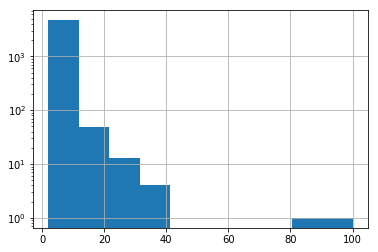

In [53]:
# products with more than 1 occurrence
product_counts = train['product'].value_counts()
product_counts[product_counts > 1].hist(log=True)

In [54]:
# Are review stars relevant?
star_stats = train.groupby(['review_stars'])['Target'].agg([np.size, np.mean])
star_stats

,size,mean
review_stars,,
1,3094,0.534906
2,1485,0.461279
3,3665,0.484857
4,9092,0.574571
5,30734,0.562179


In [55]:
# Extreme rating seem to indicate more relevant comments. Yet, there are very few moderate rating.
# Not very predictive... Let's see how much more than .5 we can reach using p(target | review_star)
mean_array = star_stats['mean']
y_pred = train['review_stars'].apply(lambda r: mean_array[r])
score_function(train['Target'], y_pred)

0.5228017844822425

                                        Plots for comment_size                                        


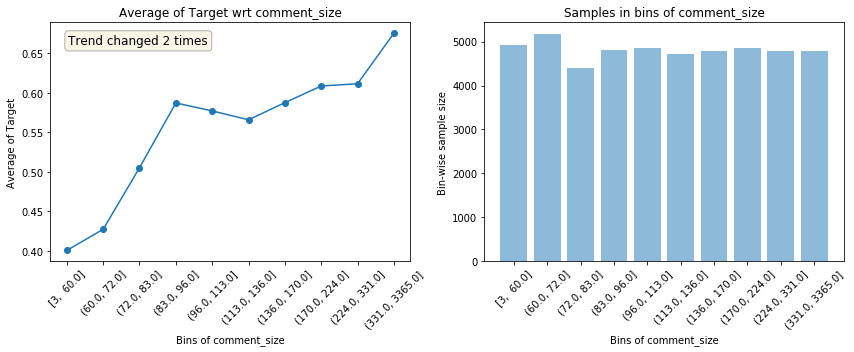

--------------------------------------------------------------------------------------------------------------




In [56]:
# Let's study basic features extracted from the comments using the featexp package (that I recommend)
# 1st plot is used to study correlation with the target
# 2nd plot is to check the size of the bins so as to avoid being fooled by subrepresentative (if that's a word) bins.

# Size is usually meaningful
train['comment_size'] = train['review_content'].apply(lambda x : len(x))
get_univariate_plots(data=train, target_col='Target', features_list=['comment_size'])

                                         Plots for title_size                                         


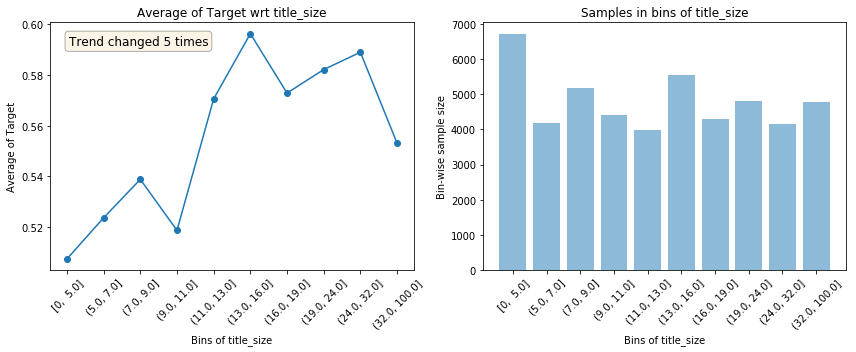

--------------------------------------------------------------------------------------------------------------




In [57]:
# let's see if the same is true with the title
train['title_size'] = train['review_title'].apply(len)
get_univariate_plots(data=train, target_col='Target', features_list=['title_size'])

                                      Plots for caps_percentage                                       


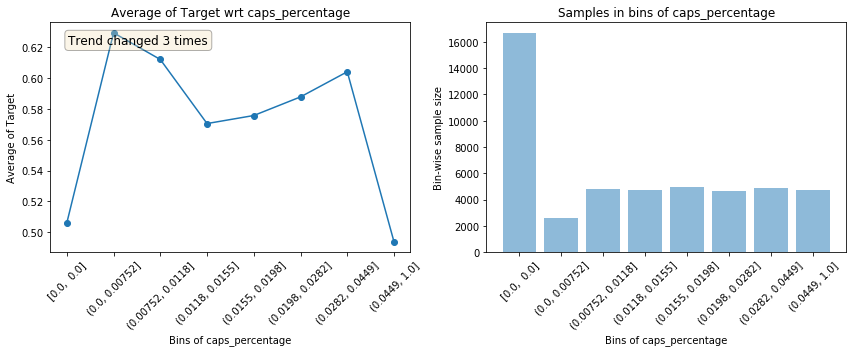

--------------------------------------------------------------------------------------------------------------




In [58]:
train['caps_percentage'] = train['review_content'].apply(lambda str: sum(1 for c in str if c.isupper()) / len(str))
get_univariate_plots(data=train, target_col='Target', features_list=['caps_percentage'])

In [59]:
#caps percentage is discriminative, but there are two modes, we can find nicer features
train = train.drop(columns=['caps_percentage'])
train['caps_at_first_letter'] = train['review_content'].apply(lambda x: x[0].isupper())
train.groupby(['caps_at_first_letter'])['Target'].agg([np.size, np.mean])

,size,mean
caps_at_first_letter,,
False,21414,0.515644
True,26656,0.584371


                              Plots for caps_at_first_letter_of_sentence                              


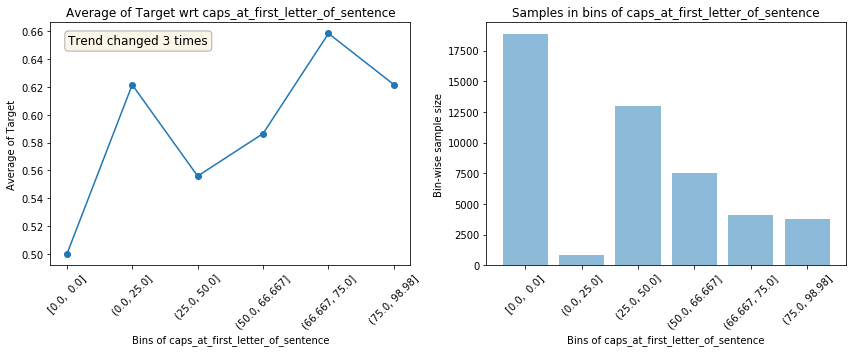

--------------------------------------------------------------------------------------------------------------




In [60]:
# counting the sentences that starts with a CAP
def sentence_count(string):
    return len(re.findall('((^\W*)|([.!?]))\s*\w', string))
def capped_sentence_count(string):
    return len(re.findall('((^\W*)|([.!?]))\s*[A-Z]', string))
train['caps_at_first_letter_of_sentence'] = train['review_content'].apply(lambda x : 100*capped_sentence_count(x)/(1+sentence_count(x)))
get_univariate_plots(data=train,target_col='Target', features_list=['caps_at_first_letter_of_sentence'])
#train.groupby(['caps_at_first_letter_of_sentence'])['Target'].agg([np.size, np.mean])

                                       Plots for sentence_count                                       


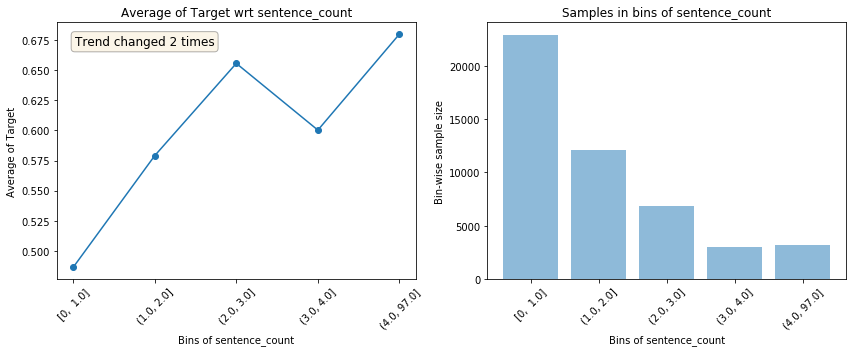

--------------------------------------------------------------------------------------------------------------




In [61]:
# Don't heed the value between 0 and 25, it is not very representative (cf plot on the left)

# Checking the number of sentences
train['sentence_count'] = train['review_content'].apply(sentence_count)
get_univariate_plots(data=train,target_col='Target', features_list=['sentence_count'])

In [62]:
# taking the log instead for more linear distribution in space
train['log_sentence_count'] = train['review_content'].apply(lambda x: np.log(1+sentence_count(x)))
train = train.drop(columns=['sentence_count'])

                                      Plots for caps_percentage                                       


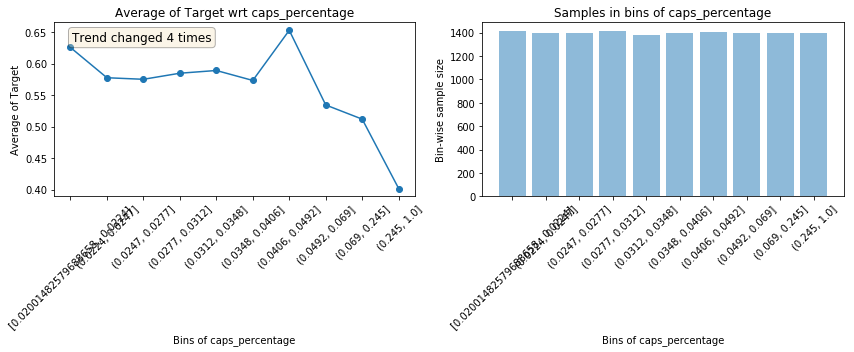

--------------------------------------------------------------------------------------------------------------




In [63]:
# Too numerous caps seemed relevant
def cap_percentage(string):
    if(string == ''):
        return 0
    cap_count = len(re.findall('[A-Z]', string))
    return cap_count/len(string)
train['caps_percentage'] = train['review_content'].apply(cap_percentage)
get_univariate_plots(data=train[train['caps_percentage']>0.02],target_col='Target', features_list=['caps_percentage'])

In [64]:
# it really goes down after 5%, creating a feature.
# That's not that many instances but that's information we have not captured yet.
train.loc[train['caps_percentage'] < 0.05, 'caps_percentage'] = 0
sum(train['caps_percentage'] > 0)

4146

                                     Plots for letter_percentage                                      


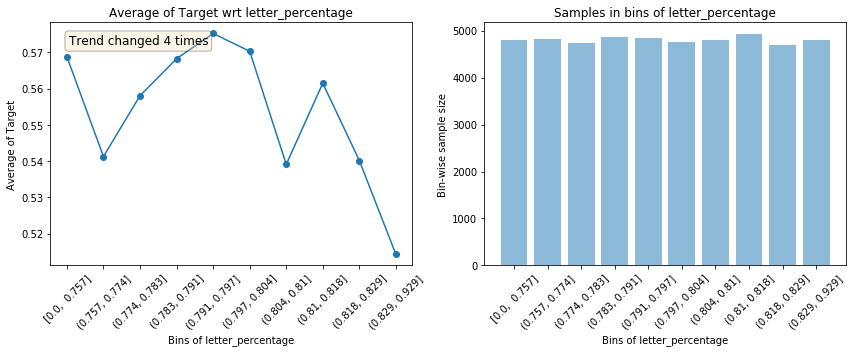

--------------------------------------------------------------------------------------------------------------




In [65]:
# special characters
train['letter_percentage'] = train['review_content'].apply(lambda x: len(re.findall('\w', x))/(1+len(x)))
get_univariate_plots(data=train,target_col='Target', features_list=['letter_percentage'])

                                     Plots for letter_percentage                                      


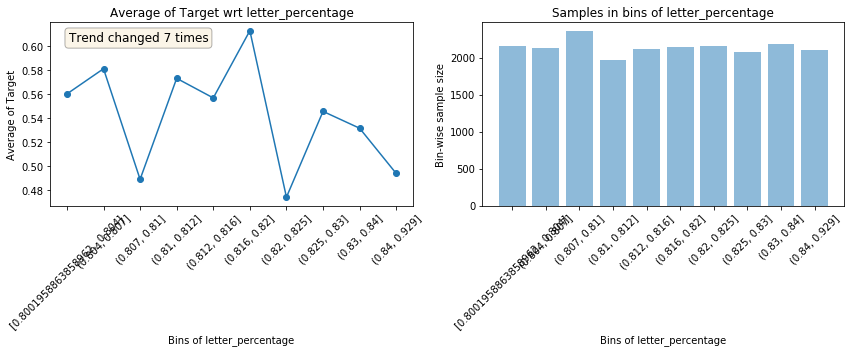

--------------------------------------------------------------------------------------------------------------




In [66]:
get_univariate_plots(data=train[train['letter_percentage']>0.8],target_col='Target', features_list=['letter_percentage'])

                                      Plots for punc_percentage                                       


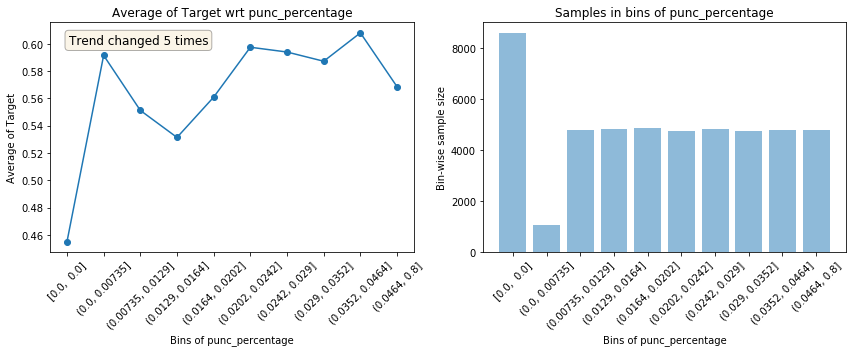

--------------------------------------------------------------------------------------------------------------




In [67]:
# dropping this one
# train = train.drop(columns=['letter_percentage'])

# counting real punctuation
train['punc_percentage'] = train['review_content'].apply(lambda x: len(re.findall('[.,;?:!-]', x))/(1+len(x)))
get_univariate_plots(data=train,target_col='Target', features_list=['punc_percentage'])

                                      Plots for punc_percentage                                       


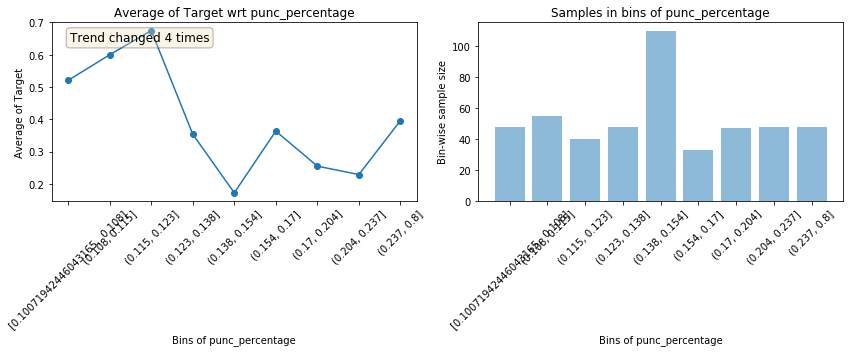

--------------------------------------------------------------------------------------------------------------




In [68]:
# 0 seems bad, then there is a slight trend
# let's see what happens after 10%
get_univariate_plots(data=train[train['punc_percentage'] > 0.1],target_col='Target', features_list=['punc_percentage'])

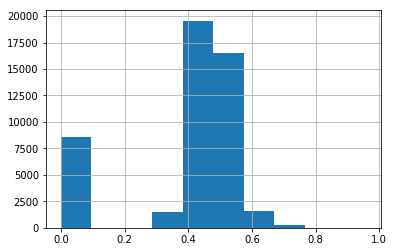

In [69]:
# too little instances, let's forget about it
np.power(train['punc_percentage'], 0.2).hist()

In [70]:
#nice
train['norm_punc_percentage'] = np.power(train['punc_percentage'], 0.2)
train = train.drop(columns=['punc_percentage'])

                                     Plots for special_percentage                                     


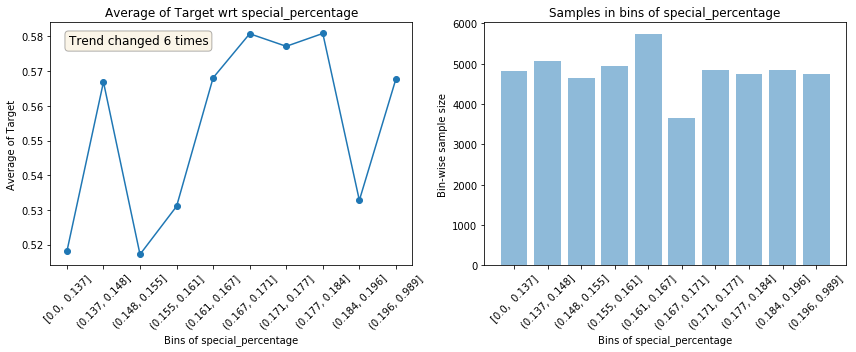

--------------------------------------------------------------------------------------------------------------




In [71]:
# special chars
def special_count(x):
    non_alpha=len(re.findall('\W', x))
    punc=len(re.findall("[',;:!.?-]", x))
    return (non_alpha - punc)/(1+len(x))
train['special_percentage'] = train['review_content'].apply(special_count) 

get_univariate_plots(data=train,target_col='Target', features_list=['special_percentage'])

In [72]:
# no clear trend
train = train.drop(columns = ['special_percentage'])

                                       Plots for caps_per_title                                       


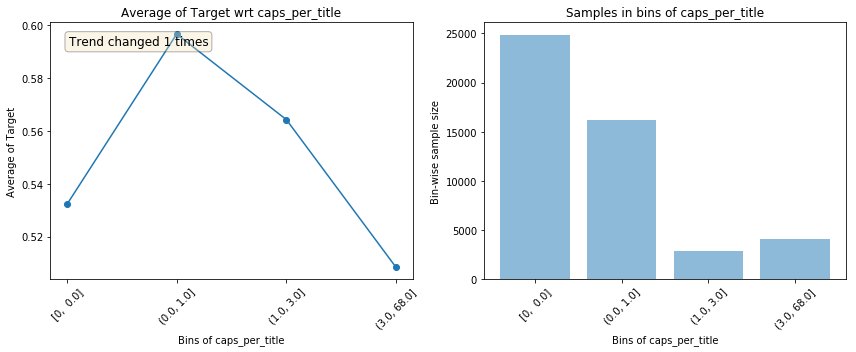

--------------------------------------------------------------------------------------------------------------




In [73]:
#quick check of the title
train['caps_per_title'] = train['review_title'].apply(lambda x : len(re.findall('[A-Z]', x)))
get_univariate_plots(data=train,target_col='Target', features_list=['caps_per_title'])

                                         Plots for title_size                                         


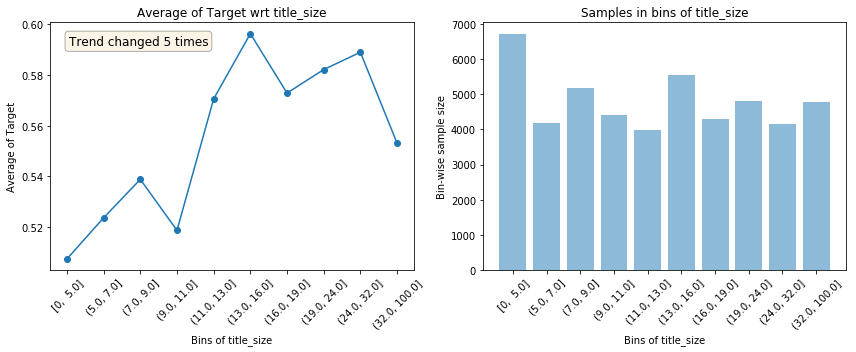

--------------------------------------------------------------------------------------------------------------




In [74]:
train['title_size'] = train['review_title'].apply(len)
get_univariate_plots(data=train,target_col='Target', features_list=['title_size'])

                                       Plots for title_letters                                        


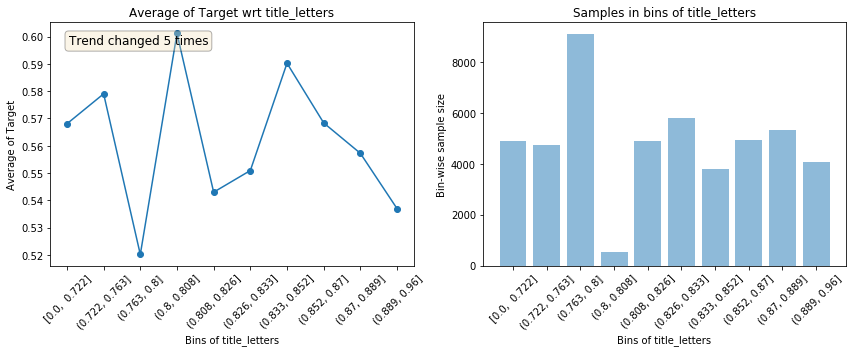

--------------------------------------------------------------------------------------------------------------




In [75]:
train['title_letters'] = train['review_title'].apply(lambda x: len(re.findall('\w', x))/(1+len(x)))
get_univariate_plots(data=train,target_col='Target', features_list=['title_letters'])

                                     Plots for title_non_letters                                      


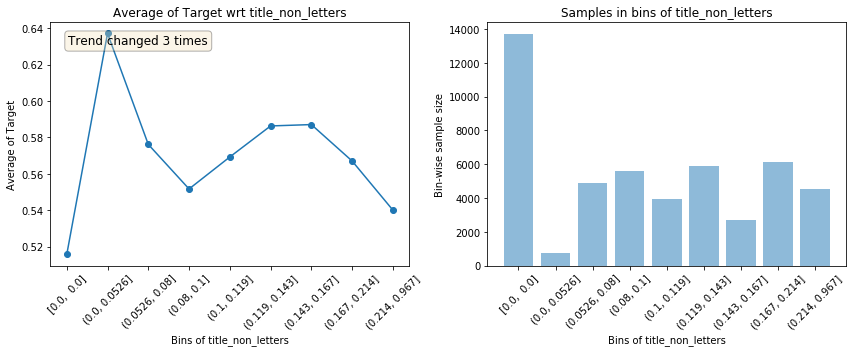

--------------------------------------------------------------------------------------------------------------




In [76]:
train['title_non_letters'] = train['review_title'].apply(lambda x: len(re.findall('\W', x))/(1+len(x)))
get_univariate_plots(data=train,target_col='Target', features_list=['title_non_letters'])

In [77]:
train['only_letters_in_title'] = train['title_non_letters'] == 0
train.groupby('only_letters_in_title')['Target'].agg([np.size, np.mean])

,size,mean
only_letters_in_title,,
False,34368,0.568930
True,13702,0.515691


In [78]:
# faily informative
train['one_cap_in_title1'] = train['review_title'].apply(lambda x: not x == '' and x[0].isupper())
train.groupby('one_cap_in_title1')['Target'].agg([np.size, np.mean])

,size,mean
one_cap_in_title1,,
False,25643,0.532270
True,22427,0.578321


In [ ]:
# a new cell :-)

In [79]:
train['one_cap_in_title2'] = train['review_title'].apply(lambda x: len(re.findall('[A-Z]', x))==1)
train.groupby('one_cap_in_title2')['Target'].agg([np.size, np.mean])

,size,mean
one_cap_in_title2,,
False,31899,0.531992
True,16171,0.596685


In [80]:
train.groupby(['one_cap_in_title1', 'one_cap_in_title2'])['Target'].agg([np.size, np.mean])

size      mean
one_cap_in_title1 one_cap_in_title2                 
False             False              25283  0.532967
                  True                 360  0.483333
True              False               6616  0.528265
                  True               15811  0.599266

In [81]:
train = train.drop(columns=['title_non_letters', 'caps_per_title', 'one_cap_in_title1', 'title_letters'])
train

,ID,review_content,review_title,review_stars,product,Target,comment_size,title_size,caps_at_first_letter,caps_at_first_letter_of_sentence,log_sentence_count,caps_percentage,letter_percentage,norm_punc_percentage,only_letters_in_title,one_cap_in_title2
0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,2fbb619e3606f9b7c213e858a109cda771aa2c47ce50d5...,0,382,55,True,75.000000,1.386294,0.000000,0.798956,0.419908,False,False
1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,7b56d9d378d9e999d293f301ac43d044cd7b4786d09afb...,1,1000,30,True,90.000000,2.302585,0.000000,0.745255,0.532852,False,False
2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,7b37bf5dcb2fafd9229897910318a7dfa11a04ca36893c...,0,192,97,True,80.000000,1.609438,0.000000,0.808290,0.434823,False,False
5,5,"Ma fille adore, elle n'en n'était pas sûre à l...",Comme Hermione,5,a1a58f0f3a35a164fa14bff9e2c1ca8c1202c31499faa1...,1,102,14,True,50.000000,0.693147,0.000000,0.766990,0.493011,False,False
6,6,très bien emballé et rapidité dans l'envoi\nbo...,jouet neuf,5,800c416d7b085527e1437de705c0dc0447d33274857752...,1,87,10,False,0.000000,0.693147,0.000000,0.818182,0.000000,False,False
7,7,super génial car j'adore cette collection supe...,top,5,d6a9d24fdb20059f9f972b18fed7eaa7fb7ea59c135a30...,1,141,3,False,0.000000,0.693147,0.000000,0.830986,0.426332,True,False
9,9,"à priori une bonne machine, assez rapide et ex...",bonne machine,4,e6418a5e8901b8ed98625432103a51c2f37aba3a644c26...,0,68,13,False,0.000000,0.693147,0.000000,0.826087,0.428776,False,False
10,10,Très belle chaîne en argent à porter avec n'im...,Chaîne argent,5,cb2ea7b84fc8eac7de35afcf0a692d6215a3bdd52272b4...,0,74,13,True,50.000000,0.693147,0.000000,0.813333,0.000000,False,True
11,11,très bon booster yu gi oh ! et difficile a av...,paquet de tournoi 7 !!!,5,7da2a16b6510206041dcfe2a246575a26a3116a196cddf...,1,83,23,False,0.000000,1.098612,0.000000,0.714286,0.543946,False,False
12,12,Les films sont très fidèles aux livres. Les de...,Fidéle,5,cc75c1f344a0a503dae765675715a9d23625cb2cff8244...,0,161,6,True,75.000000,1.386294,0.000000,0.790123,0.450320,True,True


In [82]:
train.to_pickle('rich_train.pkl')

In [ ]:
# hey hey this is new code!